За основу взял ноутбуки с уроков. 
Сделал класс для DQN чтобы собрать параметры в одно место. 
Дополнительных параметров ввел много - они не столько реально нужны, сколько добавлял для собственных экспериментов.
С Python и Pytorch раньше практически не работал, поэтому использую относительно простые задачи для собственной практики.

Задачей ставил получать среднюю награду 200 за 100 эпизодов (так вроде критерий на gymnasium определен) - побыстрее  и  постабильнее. Исходные гиперпараметры особо не тюнил, в основном пробовал их менять в процессе (в основном эпсилон) 
Для эпсилон пользовался временным увеличением при снижении награды, иной раз помогает, но процесс менее стабильный чем с обычным графиком. Линейгый график не понравился, показалось чно награда на начальном этапе медленнее с ним растет.

По сравнению с SB3
 Большинство экспериментов провел с экспоненциальным распадом, и оптимизатором AdamW, эпсилон снижал поэпизодно. 
 Потом выяснил, что в SB3 распад линейный, по шагам и оптимизатор Adam. Сделал тоже подобные варианты. Настроить AdamW в SB3 аналогичный своему сходу не получилось, поэтому просто поменял у себя оптимизатор на Adam. 

Логи tensorboard прикрутил уже под конец, статистики нормально не набрал.
Логи TB выложил вместе с ноутбуком, графики не рисовал.


# dependences for Colab 

In [35]:
if 'google.colab' in str(get_ipython()):
    !apt-get update > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
    !apt-get install x11-utils > /dev/null 2>&1
    !apt-get install xvfb > /dev/null 2>&1

In [36]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rarfile --quiet
    !pip install stable-baselines3[extra] --quiet
    !pip install ale-py --quiet
    !pip install gym[box2d] --quiet
    !pip install pyvirtualdisplay --quiet
    !pip install pyglet --quiet
    !pip install pygame --quiet
    !pip install minigrid --quiet
    !pip install -q swig --quiet
    !pip install -q gymnasium[box2d] --quiet
    !pip install 'minigrid<=2.1.1' --quiet
    !pip3 install box2d-py --quiet

# Imports

In [37]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim


import os
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from base64 import b64encode
from pyvirtualdisplay import Display
import datetime
import time

import gymnasium
import sys
sys.modules["gym"] = gymnasium

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gymnasium as gym
from gym import spaces
from gym.envs.box2d.lunar_lander import *
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output



In [38]:
seed=None
random.seed(seed)
np.random.seed(seed)
#torch.manual_seed(seed)

In [39]:
os.environ['PYVIRTUALDISPLAY_DISPLAYFD'] = '0'
# create the directory to store the video(s)
os.makedirs("./video", exist_ok=True)

display = Display(visible=False, size=(800, 600))
_ = display.start()

"""
Функция позволяет записывать видео из gym и отображать его.
Чтобы включить видео, просто выполните "env = wrap_env(env)""
"""
def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [40]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [41]:
class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [42]:
class net_model(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_config):
        super(net_model, self).__init__()
    
        self.net = nn.Sequential(nn.Linear (in_features=n_observations, out_features=hidden_config[0]),
                                 nn.ReLU(),
                                 nn.Linear (in_features=hidden_config[0], out_features=hidden_config[1]),
                                 nn.ReLU(),
                                 nn.Linear (in_features=hidden_config[1], out_features=n_actions))
        
    def forward(self, x):        
        return self.net(x)

# Класс для DQN

In [ ]:
class myDQN:    
    def __init__(self, env, *args):
        self.env  = env                         
        self.n_actions    =  self.env.action_space.n    
        self.n_observations =  self.env.observation_space.shape[0] 

        if args[0] == None:
            self.params = {                                                
                # общие                                             
                'hidden_config'         : [64,64],         # Входы и выходы скрытого слоя            
                'lr'                    : 0.001,          # Темп обучения            
                # DQN
                'rb_capacity'           : 30000,           # Размер буфера
                'gamma'                 : 0.99,            # Дискаунт
                'tau'                   : 0.005,           # Коэффициент обновления весов    
                'update'                : 1,               # Интервал для soft update, (1 если делаем на каждом шаге)         
                'batch_size'            : 128,             # Размер батча                        
                # DQN - Epsilon
                'epsilon_max'           : 0.6,             # Начальный эпсилон
                'epsilon_min'           : 0.04,         # Конечный эпсилон
                'epsilon_zero'          : 1,            # Доля эпизодов, после выполнения которых эпсилон обнуляется >= 1 - отключено
                'decay_fraction'        : 0.1,            # Число эпизодов убывания эпсилон        
                # Выдумки            
                'enable_timeout'        : False,           # True - прервать эпизод при достижении timeout_steps  
                'timeout_steps'         : 700,                  
                'early_stopping_rew'    : 300,             # Остановить обучение если средняя награда за последние 100 эпизодов выше early_stopping_rew   
                'learning_length'       : 1000,
                'length_units'          : 'ep',           # продолжительность обучения задается: 'ep' - в эпизодах, 'step' - в шагах                    
                'decay_type'            : 'exp',          # Тип распада - exp, linear            
                # Извращения
                'reward_check_period'   : 5,              # Если средняя награда уменьшилась за reward_check_period эпизодов больше чем на reward_check_delta, начать делать всякое из возможного ниже
                'reward_check_delta'    : 5,
                'cust_act_eps_thr'      : 0.051,             # с какой величины эпсилон практиковать мониторинг награды
                'enable_target_fallback': False,           # откатывать веса target_network к лучшим известным значениям
                'enable_policy_fallback': False,           # откатывать веса policy_network к лучшим известным значениям
                'enable_eps_boost'      : False,           # временно увеличивать эпсилон при снижении награды    
                'eps_boost'             : 0.1,             # Временно увеличить эпсилон на eps_boost 
                'eps_boost_length'      :500,                # На сколько эпизодов поднимать эпсилон    
                'enable_reward_change'  : False            # вместе c увеличением эпсилон штрафовать за долгие полеты
            }
        else:
            self.params = args[0]
               
        self.params['env'] = self.env.spec.id
        print(f"Environment: {self.params['env']} (S{self.n_observations}/A{self.n_actions})")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("device:", self.device)        
        
        # Инициилизировать сети: целевую и политики
        self.policy_net = net_model(self.n_observations, self.n_actions, self.params['hidden_config']).to(self.device)
        self.target_net = net_model(self.n_observations, self.n_actions, self.params['hidden_config']).to(self.device)
        
        # сеть для сохранения лучшего варианта
        self.best_model = net_model(self.n_observations, self.n_actions, self.params['hidden_config']).to(self.device)
        self.best_target = net_model(self.n_observations, self.n_actions, self.params['hidden_config']).to(self.device)
                               
        # Подгрузить в целевую сеть коэффициенты из сети политики
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        # Задать Loss-функцию 
        self.loss = nn.SmoothL1Loss()     
                
        # Задать оптимайзер
        self.optimizer = optim.Adam(self.policy_net.parameters(), self.params['lr'])
        self.scheduler = torch.optim.lr_scheduler.StepLR(
                    self.optimizer, step_size=10, gamma=0.9)
           
        # Инициализировать Replay Memory buffer
        self.memory = ReplayBuffer(self.params['rb_capacity'])
        
        # Разное 
        self.steps_done = 0
        self.episodes_done = 0
        self.force_exploration=False
        self.eps_boost_length=0
        self.best_reward = -100000
        self.prev_reward = -100000
        self.best_episode = 1
        self.best_model_timesteps = 0
        
        
        self.landed = 0
        self.crashed = 0
        self.out_of_fuel = 0           
        
        # массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
        self.episode_durations = []
        self.episode_rewards = []
        self.episode_accuracy = []
        
        self.eps_threshold=self.params['epsilon_max']
        self.eps_actual=self.eps_threshold        
        
        
        self.decay_rate  = math.exp(math.log(self.params['epsilon_min'] / self.params['epsilon_max']) / (self.params['learning_length'] * self.params['decay_fraction']))
        self.decay_delta = (self.params['epsilon_max'] - self.params['epsilon_min']) / (self.params['learning_length'] * self.params['decay_fraction'])        
        print(f"decay_rate: {self.decay_rate:.4f}")
        print(f"decay_delta: {self.decay_delta:.4f}")
                
        self.tf_writer = SummaryWriter(flush_secs = 10, comment="_CustomDQN")
        
    #-----------------------------------------------------------------------------------------------------------

    def __del__(self):
        self.tf_writer.close()
                   
    #----------------------------------------------------------------------------------------------------------- 
    
    def set_epsilon(self): #Вызывается на каждом шаге.                
        
        learning_fraction = self.episodes_done/self.params ['learning_length']
        
        if learning_fraction >= self.params ['learning_length']*self.params['epsilon_zero']:
            self.eps_threshold = 0
            self.decay_delta = 0
        
        if self.params['decay_type'] == 'exp':
            self.eps_threshold *= self.decay_rate
        elif self.params['decay_type'] == 'linear':
            self.eps_threshold -= self.decay_delta   
        else: 
            raise ValueError ("Unknown decay type")
        
        if self.eps_threshold <= self.params['epsilon_min']:
            self.eps_threshold = self.params['epsilon_min']
            self.min_eps_step=self.steps_done
                                    
        # Если просят зафорсить рандом значит, был откат. Поднимаем счетчик шагов с увеличенным эпсилон        
        if self.force_exploration == True:
            self.force_exploration = False
            self.eps_boost_length = self.params['eps_boost_length']
        
        # Увеличиваем эпсилон если требуется буст
        if self.eps_boost_length > 0:
            self.eps_boost_length -= 1    
            self.eps_actual=self.eps_threshold+self.params['eps_boost']
        else:   
            self.eps_actual=self.eps_threshold
            
        
            
            
    #-----------------------------------------------------------------------------------------------------------    
        
    def select_action(self, state): #Вызывается на каждом шаге        
                
        # случайное значение для определения какой шаг будем делать жадный или случайный
        sample = random.random()           
                                  
        # если случайный порог больше epsilon-порога
        if sample > self.eps_actual: 
            with torch.no_grad():
                # t.max(1) вернет наибольшее значение столбца в каждой строке.
                # Второй столбец в результате max - это индекс того места, 
                # где был найден максимальный элемент, 
                # поэтому мы выбираем действие с наибольшим ожидаемым вознаграждением.
                action = self.policy_net(state).max(1)[1].view(1, 1)
        else:
            # Иначы выбираем случайное дайствие            
            action =  torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)
            
        return action    
            
    #-----------------------------------------------------------------------------------------------------------    
   
    def optimizatiom_step(self):
                
        # Проверить достаточно ли данных на полный батч    
        if len(self.memory) < self.params['batch_size']:
            return
        
        # Получить из памяти батч
        transitions = self.memory.sample(self.params['batch_size'])
        
        # Преобразовать его в namedtuple
        batch = Transition(*zip(*transitions))

        # Вычислить маску нефинальных состояний и соединить элементы батча
        # (финальным состоянием должно быть то, после которого моделирование закончилось)

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=self.device, dtype=torch.bool)
        
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        
        # Собираем батчи для состояний, действий и наград
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Вычислить Q(s_t, a) - модель вычисляет Q(s_t), 
        # затем мы выбираем столбцы предпринятых действий. 
        # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Вычислить V(s_{t+1}) для всех следующих состояний.
        # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются 
        # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
        # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния, 
        # либо 0, если состояние было финальным.
        next_state_values = torch.zeros(self.params['batch_size'], device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Вычисляем ожидаемые Q значения
        expected_state_action_values = (next_state_values * self.params['gamma']) + reward_batch

        # Объединяем все в общий лосс
        criterion = self.loss
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Готовим градиент
        self.optimizer.zero_grad()
        loss.backward()
        # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)        
        self.optimizer.step()    
        self.steps_done +=1
        
        
    #-----------------------------------------------------------------------------------------------------------   
    
    def run_episode(self):
        
        episode_reward = 0
        episode_cur_step = 1
        episode_finished = False
        learning_finished = False
        
      
        # Для каждого эпизода инициализируем начальное состояние
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        
        # выполняем действия пока не получим флаг done
        # t - считает сколько шагов успели сделать пока эпизод не закончился'
        while not episode_finished:
            # выбираем действие 
            action = self.select_action(state)
            
            # Делаем шаг
            observation, reward, terminated, truncated, _ = self.env.step(action.item())
                            
            # Объединяем done по двум конечным состояниям + по достижению заданного лимита шагов
            timeout = truncated or (episode_cur_step>=self.params['timeout_steps'] and self.params['enable_timeout']==True)
                        
            done = terminated or timeout
                        
            if terminated == True:
                if reward == 100:
                    self.landed +=1
                if reward == -100:
                    self.crashed +=1                           
                
            if timeout == True:                    
                self.out_of_fuel +=1
        
            #Агент штрафуется дополнительно
            if self.params['enable_reward_change'] and self.eps_boost_length + 1 > 0:   
                #дополнительный штраф за расход топлива 
                reward -= 0.01
                #дополнительный штраф за отклонение от центра 
                reward -= abs(observation[0])*0.05 
        
            # в статистику идет награда от окружения, c доп. штрафом. Реальные средние будет видно на тестировании
            episode_reward += reward   
                    
            # Преобразуем в тензор
            reward = torch.tensor([reward], device=self.device)
                            
            # присваиваем следующее состояние (было почему-то тлько для terminated, хотя done тоже терминальное)
            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

            # отправляем в память
            self.memory.push(state, action, next_state, reward)

            # переходим на следующее состояние
            state = next_state

            # запускаем обучение сети
            self.optimizatiom_step()     
                         
            # уменьшаем эпсилон 
            if self.params['length_units'] == 'step' or (self.params['length_units'] == 'ep' and episode_cur_step == 1): 
                self.set_epsilon()          

            if self.steps_done % self.params['update'] == 0:  # Интервал обновления
                # делаем "мягкое" обновление весов
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.params['tau'] + target_net_state_dict[key]*(1-self.params['tau'])
                self.target_net.load_state_dict(target_net_state_dict)                
        
            # Если получили terminated or truncated завершаем эпизод обучения
            if done:
                # добавляем в массив продолжительность эпизода
                self.episode_durations.append(episode_cur_step)
                self.episode_rewards.append(episode_reward)
                self.episode_accuracy.append(1-abs(observation[0]))
                                
                episode_finished = True             
                self.episodes_done +=1
                if self.params['length_units'] == 'ep' and self.episodes_done == self.params['learning_length']:
                    learning_finished = True                    
                                           
            if self.params['length_units'] == 'step' and self.steps_done == self.params['learning_length']:
                learning_finished = True
                
            episode_cur_step +=1
        # считаем средние
        mean_rew_100 = np.mean(self.episode_rewards[-100:])            
        mean_step_100 = np.mean(self.episode_durations[-100:])
        std_rew_100 = np.std(self.episode_rewards[-100:])
        std_step_100 = np.std(self.episode_durations[-100:])
        mean_acc_100 = np.mean(self.episode_accuracy[-100:])
        if mean_rew_100>200:        
            self.scheduler.step()   
        
        # Если средняя награда за 100 эпизодов больше заданной, останавливаем обучение 
        if mean_rew_100>self.params['early_stopping_rew']:
            learning_finished = True
        
        # проверяем наличие лучшей модели и копируем ее 
        if mean_rew_100 > self.best_reward:
            self.best_reward = mean_rew_100
            self.best_episode= self.episodes_done
            self.best_model.load_state_dict(self.policy_net.state_dict())
            self.best_target.load_state_dict(self.target_net.state_dict())
            self.best_model_timesteps = self.steps_done
            
        # проверяем динамику средней награды. Если падает, делаем всякое            
        if self.episodes_done % self.params['reward_check_period'] == 0:                                 
            if self.eps_threshold<self.params['cust_act_eps_thr']: 
                if mean_rew_100 < self.prev_reward - self.params['reward_check_delta']:
                        # Откат таргетов
                        if self.params['enable_target_fallback']:
                            self.target_net.load_state_dict(self.best_target.state_dict())  
                        # Откат политики
                        if self.params['enable_policy_fallback']:                                
                            self.policy_net.load_state_dict(self.best_model.state_dict())                            
                        # увеличиваем эпсилон на время     
                        if self.params['enable_eps_boost']:                                
                            self.force_exploration = True                                         
            self.prev_reward = mean_rew_100 
            
        # лог на экран
        clear_output(wait=True)
        print(f'Episode: {self.episodes_done} done. Total steps {self.steps_done}, reward: {episode_reward}')
        print(f'Reward/100ep mean/std: {mean_rew_100:3.1f}/{std_rew_100:3.1f}(best {self.best_reward:3.1f}/prev {self.prev_reward:3.1f})')
        print(f'Steps/100ep mean/std: {mean_step_100:3.1f}/{std_step_100:3.1f}')
        print(f'Landed:{self.landed}/Crashed:{self.crashed}/Out of fuel:{self.out_of_fuel}. EPS={self.eps_actual:1.4f}')      
            
        # Записываем показатели эпизода        
        self.tf_writer.add_scalar('reward/Ep.reward', episode_reward, self.steps_done)            
        self.tf_writer.add_scalar('reward/100 eps. mean',mean_rew_100, self.episodes_done)
        self.tf_writer.add_scalar('reward/100 eps. mean/steps',mean_rew_100, self.steps_done)                        
        self.tf_writer.add_scalar('length/Ep. length',episode_cur_step, self.steps_done)      
        self.tf_writer.add_scalar('length/100 eps. mean',mean_step_100, self.episodes_done)
        self.tf_writer.add_scalar('length/100 eps. mean/steps',mean_step_100,self.steps_done) 
        if self.crashed>0 or self.out_of_fuel>0:
            self.tf_writer.add_scalar('stats/Success ratio', mean_acc_100 * self.landed / (self.crashed + self.out_of_fuel), self.steps_done)
        if self.crashed>0:
            self.tf_writer.add_scalar('stats/Safety ratio', self.out_of_fuel / self.crashed, self.episodes_done)  
        self.tf_writer.add_scalar('stats/Accuracy', mean_acc_100, self.episodes_done)     
        self.tf_writer.add_scalar('exploration/Epsilon threshhold',self.eps_threshold, self.episodes_done)
        self.tf_writer.add_scalar('exploration/Actual epsilon',self.eps_actual, self.episodes_done)    
        self.tf_writer.add_scalar('exploration/Actual epsilon/steps',self.eps_actual, self.steps_done)    
        
              
        
        return learning_finished
    #-----------------------------------------------------------------------------------------------------------
    
    def learn_model(self):
        
        learning_finished = False       
        
        #pbar = tqdm(range(episodes))
        #for i_episode in pbar:
        
        # Выполняем, пока не закончится обучение
        while not learning_finished:
    
            learning_finished = self.run_episode()           
            #pbar.set_description(f'Rew/100ep mean/std: {mean_rew_100:3.1f}/{std_rew_100:3.1f}(best {self.best_reward:3.1f}/prev {self.prev_reward:3.1f}/{i}) | Steps/100ep mean/std: {mean_step_100:3.1f}/{std_step_100:3.1f}. Landed:{landed}/Crashed:{crashed}/Out of fuel:{out_of_fuel}. EPS={self.eps_actual:1.4f}')                               
            
        print('Complete')
        print(f'Best mean reward for 100 eps: {self.best_reward}. Achieved at ep #{self.best_episode}. Timesteps done for best model: {self.best_model_timesteps}.')
        print(f'Total timesteps: {self.steps_done}.')
        state = {'info':      f"{self.env}: DQN, Reward:{self.best_reward:3.1f}",     
                 'date':      datetime.datetime.now(),  
                 'model':     str(self.best_model),
                 'state' :    self.best_model.state_dict(),  
        } 
        os.makedirs("./models", exist_ok=True)        
        torch.save(state, f"./models/{self.params['env']}_hiddens_{'_'.join([str(x) for x in self.params['hidden_config']])}_Reward_{self.best_reward:3.1f}.pt")
        
        # Записываем параметры эксперимента
        # self.tf_writer.add_hparams(self.params,
        #               {'hparam/best_ep_reward': self.best_reward, 
        #                'hparam/best_episode': self.best_episode})
        self.tf_writer.flush()               
    
    #-----------------------------------------------------------------------------------------------------------
    
    def test_best_model(self, episodes = 1000, ticks = 1000, render = False):       
        if render:
            vid = VideoRecorder(self.env, path=f"video/{self.params['env']}_learned.mp4")  
        rewards = []
        steps = []
        for episode in tqdm(range(1, episodes+1)):
            ep_reward = 0
            observation, _ =  self.env.reset()
            for t in range(ticks):
                if episode>=episodes-10:
                    if render:
                        self.env.render()
                        vid.capture_frame()
                obs_tensor = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)  
                
                with torch.no_grad():
                    action=self.best_model(obs_tensor).max(1)[1].view(1, 1).item()                                                  

                observation, reward, terminated, truncated, _ = self.env.step(action)
                
                ep_reward += reward                
                if terminated or truncated:
                    break
            rewards.append(ep_reward)
            steps.append(t)
        #Гистограмма наград
        print (f'Средняя награда за {episodes} эп.:{np.mean(rewards)}')
        print (f'Среднее к-во шагов за {episodes} эп.:{np.mean(steps)}')
        plt.hist(rewards, bins=100)
        plt.title(f"Best model rewards histogram, {episodes} episodes.")
        os.makedirs("./plots", exist_ok=True)
        plt.savefig (f"./plots/Test_{self.params['env']}_hiddens_{'_'.join([str(x) for x in self.params['hidden_config']])}_Reward_{self.best_reward:3.1f}.jpg")
        plt.show()   
        plt.close()
        
        vid.close()        




# Обучаем LunarLanderV2 - самодельный DQN
1 - готовим модель

In [44]:
params = {     
                # общие                                             
                'hidden_config'         : [64,64],         # Входы и выходы скрытого слоя            
                'lr'                    : 0.001,          # Темп обучения            
                # DQN
                'rb_capacity'           : 1000000,           # Размер буфера
                'gamma'                 : 0.99,            # Дискаунт
                'tau'                   : 0.005,           # Коэффициент обновления весов    
                'update'                : 1,               # Интервал для soft update, (1 если делаем на каждом шаге)         
                'batch_size'            : 32,             # Размер батча                        
                # DQN - Epsilon
                'epsilon_max'           : 0.6,             # Начальный эпсилон
                'epsilon_min'           : 0.01,         # Конечный эпсилон
                'epsilon_zero'          : 1,            # Доля эпизодов, после выполнения которых эпсилон обнуляется >= 1 - отключено
                'decay_fraction'        : 0.08,            # Число эпизодов убывания эпсилон        
                # Выдумки            
                'enable_timeout'        : False,           # True - прервать эпизод при достижении timeout_steps  
                'timeout_steps'         : 700,                  
                'early_stopping_rew'    : 300,             # Остановить обучение если средняя награда за последние 100 эпизодов выше early_stopping_rew   
                'learning_length'       : 1000000,
                'length_units'          : 'step',         # продолжительность обучения задается: 'ep' - в эпизодах, 'step' - в шагах                    
                'decay_type'            : 'exp',          # Тип распада - exp, linear                 
                # Извращения
                'reward_check_period'   : 3,              # Если средняя награда уменьшилась за reward_check_period эпизодов больше чем на reward_check_delta, начать делать всякое из возможного ниже
                'reward_check_delta'    : 5,               
                'cust_act_eps_thr'      : 0.011,             # с какой величины эпсилон практиковать мониторинг награды
                'enable_target_fallback': False,           # откатывать веса target_network к лучшим известным значениям
                'enable_policy_fallback': False,           # откатывать веса policy_network к лучшим известным значениям
                'enable_eps_boost'      : True,           # временно увеличивать эпсилон при снижении награды    
                'eps_boost'             : 0.02,             # Временно увеличить эпсилон на eps_boost 
                'eps_boost_length'      : 500,              # На сколько единиц длительности поднимать эпсилон    
                'enable_reward_change'  : False            # вместе c увеличением эпсилон штрафовать за долгие полеты
                }      

env_name = "LunarLander-v2" 
env = gym.make(env_name, continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="rgb_array")
env.reset()
mydqn = myDQN(env, params)




Environment: LunarLander-v2 (S8/A4)
device: cuda
decay_rate: 0.9999
decay_delta: 0.0000


2 - запускаем обучение

In [45]:
st=time.time()
mydqn.learn_model()
elapsed_time = time.time() - st
print('Время исполнения:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Episode: 2966 done. Total steps 1000457, reward: 139.70644166438342
Reward/100ep mean/std: 247.6/52.1(best 267.5/prev 250.2)
Steps/100ep mean/std: 316.3/187.4
Landed:2652/Crashed:129/Out of fuel:185. EPS=0.0100
Complete
Best mean reward for 100 eps: 267.45965321069224. Achieved at ep #1093. Timesteps done for best model: 407523.
Total timesteps: 1000457.
Время исполнения: 01:41:45


Тестируем лучшую модель

100%|██████████| 100/100 [00:26<00:00,  3.74it/s]

Средняя награда за 100 эп.:248.91552485505144
Среднее к-во шагов за 100 эп.:313.72


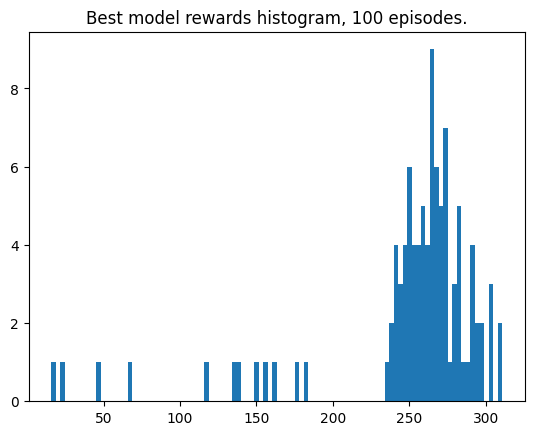

Moviepy - Building video video/LunarLander-v2_learned.mp4.
Moviepy - Writing video video/LunarLander-v2_learned.mp4



Moviepy - Done !
Moviepy - video ready video/LunarLander-v2_learned.mp4


In [46]:
mydqn.test_best_model (episodes = 100, ticks = 1000, render = True)
html = render_mp4(f"video/{mydqn.params['env']}_learned.mp4")
HTML(html)

# Готовим аналогичный конфиг для StableBaselines

In [47]:
log_dir = "runs"
os.makedirs(log_dir, exist_ok=True)

#env_name = "LunarLander-v2" 
#env = gym.make(env_name, continuous=False, gravity=-10.0,
#               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="rgb_array")
env.reset() # Используем ранее созданный

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

nn_layers = [64]  # Это конфигурация вашей нейронной сети. В настоящее время у нас есть два слоя, каждый из которых состоит из 64 нейронов.
                      # Если вам нужны три слоя по 64 нейрона в каждом, установите значение [64,64,64] и так далее.

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
optimizer_class = dict(amsgrad=False)
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", 
            env,
            policy_kwargs = policy_kwargs, 
            #optimizer_class=AdamW, 
            #optimizer_kwargs=dict(amsgrad=False),  
            tensorboard_log="runs",
            learning_rate=mydqn.params['lr'],
            batch_size=mydqn.params['batch_size'],  # for simplicity, we are not doing batch update.
            buffer_size=mydqn.params['rb_capacity'],  # size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1,  # learning starts immediately!
            gamma=mydqn.params['gamma'],  # discount facto. range is between 0 and 1.
            tau = mydqn.params['tau'],  # the soft update coefficient for updating the target network
            target_update_interval=mydqn.params['update'],  # update the target network immediately.
            train_freq=(1,"step"),  # train the network at every step.
            max_grad_norm = 10,  # the maximum value for the gradient clipping
            exploration_initial_eps = mydqn.params['epsilon_max'],  # initial value of random action probability
            exploration_final_eps = mydqn.params['epsilon_min'],
            exploration_fraction = mydqn.params['decay_fraction']*0.7, # fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1,  # number of gradient steps
            stats_window_size = 100,
            seed = None,  # seed for the pseudo random generators
            verbose=0)  # Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

In [48]:
#Заряжаем на количество шагов за которое отстрелялось DQN
model.learn(total_timesteps= mydqn.steps_done, log_interval=1, callback=callback)

Eval num_timesteps=10000, episode_reward=-138.02 +/- 60.59
Episode length: 596.40 +/- 227.95
New best mean reward!
Eval num_timesteps=20000, episode_reward=-65.01 +/- 34.84
Episode length: 571.40 +/- 364.31
New best mean reward!
Eval num_timesteps=30000, episode_reward=-24.63 +/- 18.83
Episode length: 678.20 +/- 395.31
New best mean reward!
Eval num_timesteps=40000, episode_reward=-29.94 +/- 30.63
Episode length: 483.80 +/- 421.49
Eval num_timesteps=50000, episode_reward=49.01 +/- 19.37
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=131.70 +/- 70.14
Episode length: 898.40 +/- 88.12
New best mean reward!
Eval num_timesteps=70000, episode_reward=202.05 +/- 31.66
Episode length: 511.40 +/- 77.23
New best mean reward!
Eval num_timesteps=80000, episode_reward=88.57 +/- 90.75
Episode length: 891.40 +/- 107.56
Eval num_timesteps=90000, episode_reward=41.15 +/- 121.56
Episode length: 882.80 +/- 234.40
Eval num_timesteps=100000, episode_reward=13

KeyboardInterrupt: 

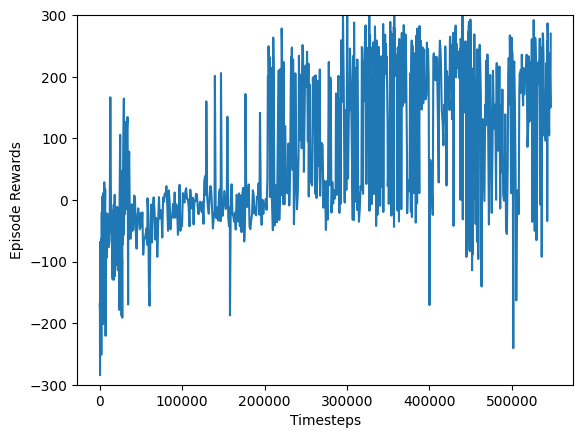

In [ ]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x, y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()